# Clustering tweets

The data is collected and prepared (to the best of my ability). Now it is time to cluster it! This is based on a [simple recipe](https://nlpforhackers.io/recipe-text-clustering/). Before moving to actual code, it is important to know what is underlying.

## TF-IDF terms

Machine learning models understand only one thing: numbers. There are many possible conversions: bag-of-words; one-hot encoding... But for the purposes of clustering, [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is the chosen approach here. It stands for **term frequency-inverse document frequency** (tf-idf) and it is composed by two components.

### term frequency (tf)

- term frequency is the number of times a term occurs in a document (or tweet).
- given that documents have different lengths, the term frequency is weighted.
- keep in mind, this is a measure for each tweet, or row in the dataset; not an aggregation.

According to the wikipedia link above, one could define term-frequency according to one of four measures. For the sake of example, let us go over _augmented frequency_. Let $f_{t,d}$ denote frequency of term $t$ in document $d$, or raw count. To prevent bias towards longer documents, an augmented frequency $t(f,d)$ measure divides raw frequency of term by that of the maximum frequency found in $d$ and weighs it according to the following

$$tf(t,d)=0.5 + 0.5\frac{f_{t,d}}{max\{f_{t',d}:t' \in{d}\}}$$

### inverse document frequency (idf)
Motivation:
- "Hence an inverse document frequency factor is incorporated which diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely."
- This keeps very frequent words, such as 'the', in mind.
- The specificity of a term can be quantified as an inverse function of the number of documents in which it occurs.

The inverse document frequency captures whether a word is common or rare across all documents (or tweets ;D). Let $|D| = N$ be the number of tweets in our dataset; and $\vert\{d \in D : t \in d\}\vert$ be the number of documents containing the term $t$. The inverse document frequency is given by:

$$idf(t, D)=log \frac{D}{|\{d \in D : t \in d\}|+1}$$

where $+1$ is there simply to prevent division by $0$.

### bringing together tf-idf
Finally, tf-idf is simply

$$tfidf(t, d, D) = tf(t, d)\space. idf(t,D)$$

which, in this specific context, denotes term frequency-inverse document frequency of term $t$, in tweet $d$ over the (data)set of tweets $D$. Let's go over some corner cases:
- if a term $t$ shows up in all the documents
    - then $idf(t,d) \approx 1$
    - then $tfidf(t,d,D) \approx tf(t,d)$
    - the term $t$ is considered frequent across all documents, meaning that it is probably some generic term such as "the".
- if a term $t$ shows up (almost) nowhere
    - then we are in the presence of low-document frequency of the term.
    - then $idf(t,d) > 1$.
    - then $tfidf(t,d,D)$ becomes amplified by $idf(t,d)$, meaning that the term $t$ points to some specific content.

## K-means algorithm

I'll be brief here... The k-means algorithm is a clustering method that operates on a notion of distance. Say, for data instances $i,j$ in the coordinate space $\{x_1, x_2, x_3\}$, their distance is described, for instance, by an Euclidean distance. In this case, $tfidf(t, d, D)$ of the many terms $t$ present in the corpus of this dataset provide the coordinate space for these distances.

As for basic algorithmic details, the reader is pointed to this [wikipedia subsection](https://en.wikipedia.org/wiki/K-means_clustering#Standard_algorithm), but youtube videos are also good if you like them more.

## code

In [15]:
import pickle
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import collections

In [4]:
with open('faved_tweets.df', 'rb') as handle:
    df = pickle.load(handle) 

/home/burnie/.conda/envs/pytorch/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
df.head()

,screen_name,text,favorite_count
date_time,,,
2017-09-30 08:02:01,ThePracticalDev,step better code author @isaacandsuch,62
2017-09-29 09:14:42,d_vf,publish understand energi bill,1
2017-09-29 04:26:45,sehurlburt,ye make sure adequ cat photo benchmark talk cu...,70
2017-09-28 16:28:28,ThePracticalDev,code think sever dimens author @andreaskling,61
2017-09-28 08:21:39,azool_97,@pewdiepi kimi na wa use heavili japanes idea ...,142


This data preparation was already done in [`cleaning-data.ipynb`](./cleaning-data.ipynb) (although I may regret using `PorterStemmer()` there...). We only need to take one column from `df` and feed a function that splits the sentence it a list of words.

In [10]:
tweets = df['text'].tolist()

def tokenize(text):
    return text.split()

tokenize(tweets[0])

['step', 'better', 'code', 'author', '@isaacandsuch']

In [13]:
# adapted from https://nlpforhackers.io/recipe-text-clustering/
def cluster_texts(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(tokenizer=tokenize, # the function defined just above
                                 max_df=0.5,
                                 min_df=0.00001,
                                 lowercase=True)
 
    tfidf_model = vectorizer.fit_transform(texts)
    km_model = KMeans(n_clusters=clusters)
    km_model.fit(tfidf_model)
 
    clustering = collections.defaultdict(list)
 
    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)
 
    return clustering

In [17]:
clusters = cluster_texts(tweets)

## visualizing clusters

In [39]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

In [40]:
wc = WordCloud()
c1 = ' '.join(df['text'][clusters[0]].tolist())
c2 = ' '.join(df['text'][clusters[1]].tolist())
c3 = ' '.join(df['text'][clusters[2]].tolist())

In [63]:
def countem(cluster, most_common=5, display=False):
    ctr = Counter()
    for word in cluster.split():
        ctr[word] += 1
    return ctr.most_common(most_common)

### cluster 1

[('game', 41), ('research', 13), ('make', 9), ('ai', 8), ('@sehurlburt', 7)]


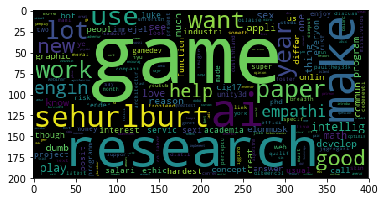

In [64]:
print(countem(c1)); plt.imshow(wc.generate(c1).to_array())

### cluster 2

[('like', 40), ('@sehurlburt', 37), ('make', 35), ('new', 34), ('think', 33), ('peopl', 33), ('get', 32), ('want', 31), ('work', 29), ('use', 28), ('author', 24), ('one', 24)]


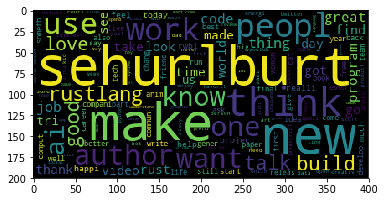

In [67]:
print(countem(c2, 12)); plt.imshow(wc.generate(c2).to_array())

### cluster 3

[('learn', 57), ('deep', 14), ('machin', 10), ('author', 6), ('new', 6)]


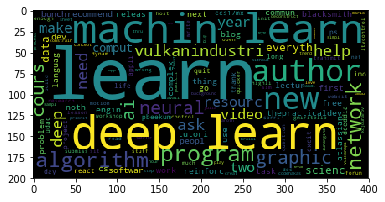

In [58]:
print(countem(c3)); plt.imshow(wc.generate(c3).to_array())